In [1]:
# Install transformers library into the session
%%capture
!pip install transformers

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan  8 08:54:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabites of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabites of available RAM

Not using a high-RAM runtime


In [4]:
# Import pre-requisite dependancies
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLOR_PALETTE = ["#08519c", "#3182bd", "#6baed6", "#9ecae1", "#c6dbef", "#e6f5f0"]

sns.set_palette(sns.color_palette(COLOR_PALETTE))

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [5]:
import os
from google.colab import drive

In [6]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/course_recommendation/reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [8]:
df.shape

(15746, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


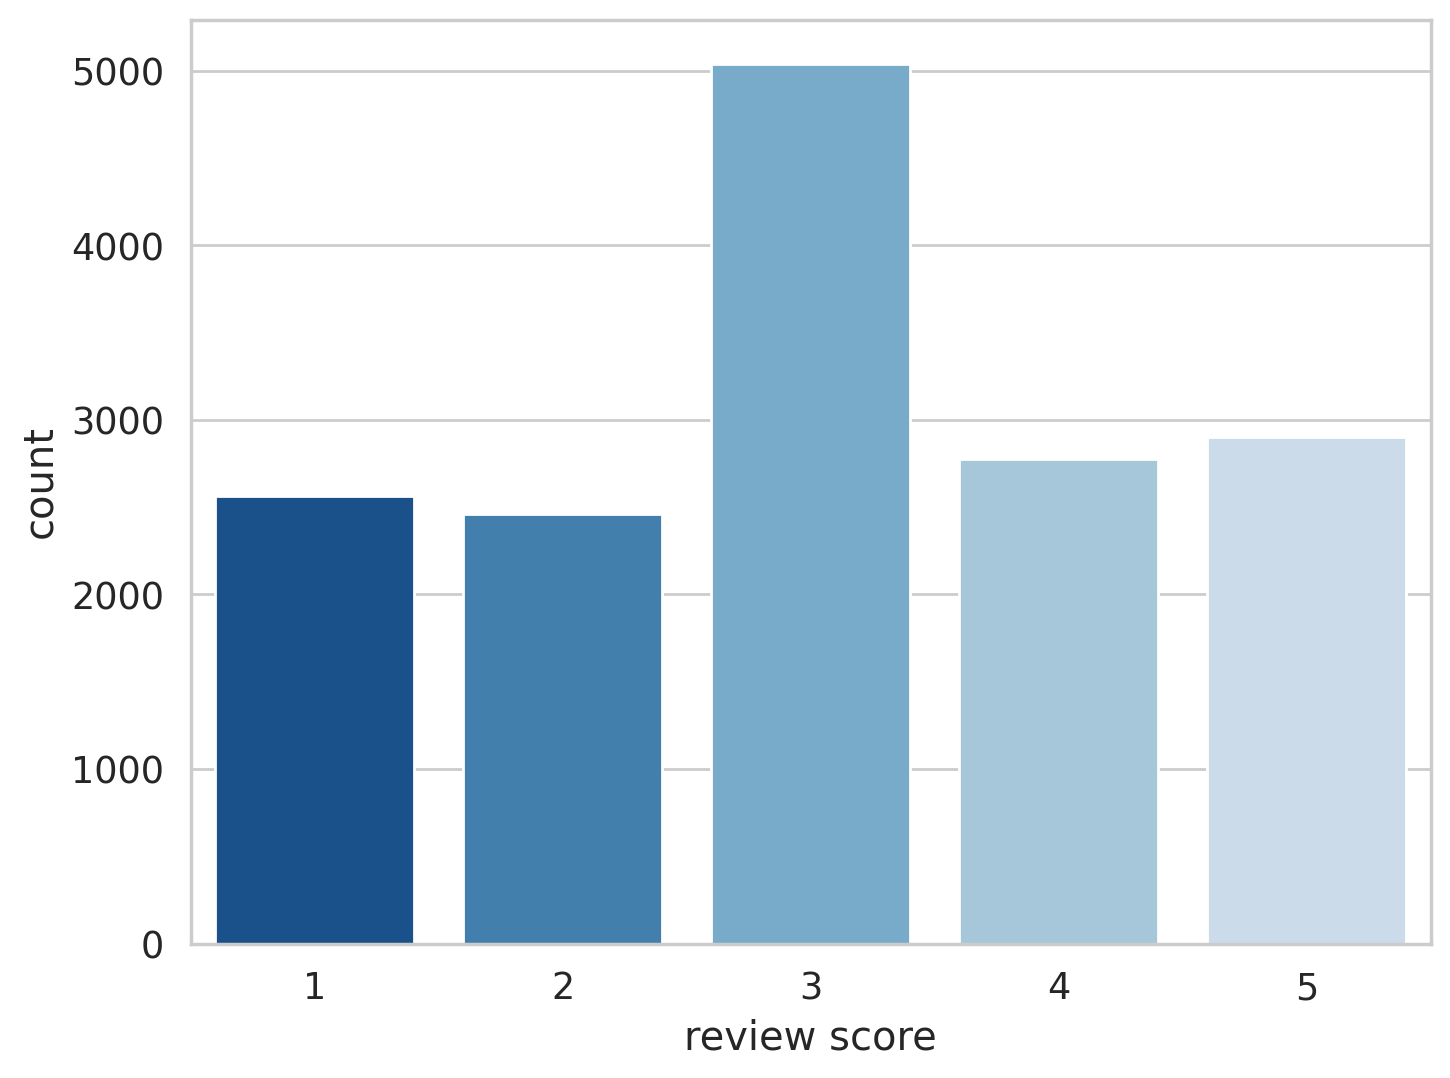

In [10]:
# Check if the dataset is balanced
sns.countplot(x='score', data=df)
plt.xlabel('review score');

In [11]:
# Create a function to label the reviews with the sentiment classes
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [12]:
# label the reviews in the dataset
df['sentiment'] = df.score.apply(to_sentiment)

In [13]:
# Define the sentiment classes
sentiment_classes = ['negative', 'neutral', 'positive']

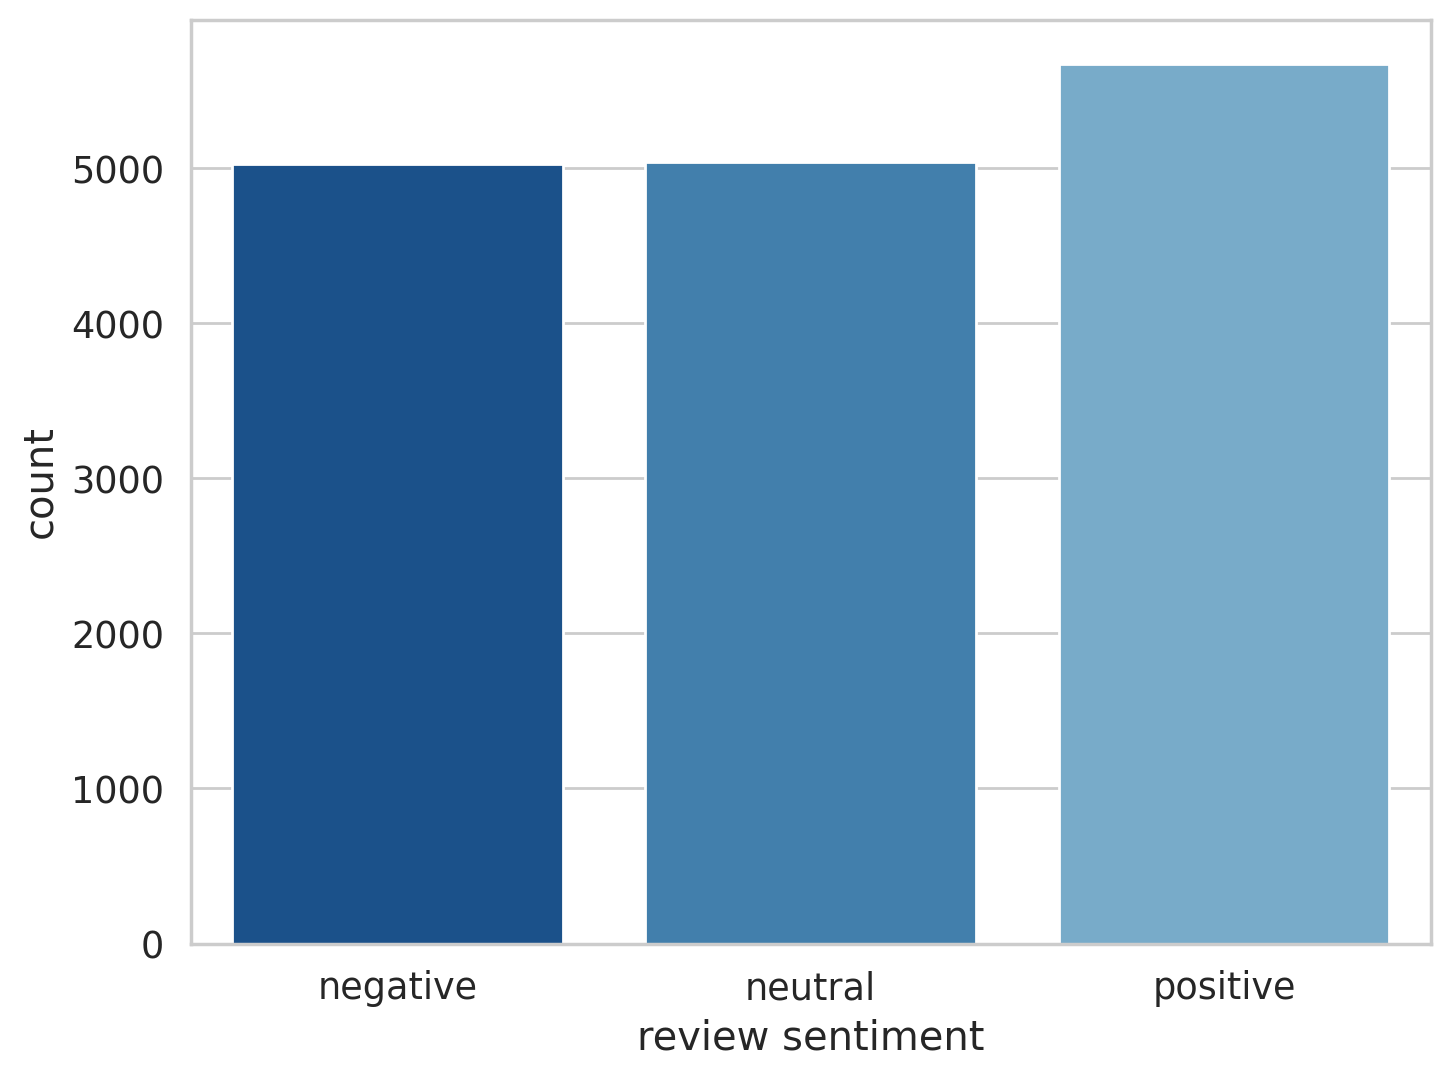

In [14]:
# Check whether the sentiment classes in the dataset are balanced
ax = sns.countplot(x='sentiment', data=df)
plt.xlabel('review sentiment')
ax.set_xticklabels(sentiment_classes);

# Data Preprocessing

In [15]:
# Define the pre-trained models
pre_trained_bert = 'bert-base-cased'
pre_trained_roberta = 'roberta-base'

In [16]:
# Get the bert tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [17]:
# Get the robert tokenizer
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
sample_txt = 'I really LOVE this product'

In [19]:
# Tokenize the sample text using the bert model
bert_tokens = bert_tokenizer.tokenize(sample_txt)

# Tokenize the sample text using the roberta model
roberta_tokens = roberta_tokenizer.tokenize(sample_txt)

In [20]:
# Display the bert tokens
bert_tokens

['I', 'really', 'L', '##O', '##VE', 'this', 'product']

In [21]:
# Display the roberta tokens
roberta_tokens

['I', 'Ġreally', 'ĠLOVE', 'Ġthis', 'Ġproduct']

In [22]:
# Convert the bert tokens to token ids
bert_token_ids = bert_tokenizer.convert_tokens_to_ids(bert_tokens)
bert_token_ids

[146, 1541, 149, 2346, 17145, 1142, 3317]

In [23]:
# Convert the roberta tokens to token ids
roberta_token_ids = bert_tokenizer.convert_tokens_to_ids(roberta_tokens)
roberta_token_ids

[146, 100, 100, 100, 100]

The BERT and RoBERTa models tokenize text differently. From the output we can tell that the RoBERTa model doesn't require as much token ids to represent tokens from text compared to the BERT model

In [24]:
# separator token
bert_tokenizer.sep_token, bert_tokenizer.sep_token_id

('[SEP]', 102)

In [25]:
# Try and see if the roberta model has special tokens
roberta_tokenizer.sep_token, roberta_tokenizer.sep_token_id

('</s>', 2)

From the output above we can see that both have the separator token, which are both represented differently for the respective models.

In [26]:
# Encode the sample text using the bert tokenizer
bert_encoding = bert_tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    truncation = True,
    add_special_tokens = True,
    padding = 'max_length',
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

# Encode the sample text using the roberta tokenizer
roberta_encoding = roberta_tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    truncation = True,
    add_special_tokens = True,
    padding = 'max_length',
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

In [27]:
bert_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [28]:
roberta_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [29]:
# Display the input ids of the sample text encoded by bert
bert_encoding['input_ids']

tensor([[  101,   146,  1541,   149,  2346, 17145,  1142,  3317,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [30]:
# Display the input ids of the sample text encoded by roberta
roberta_encoding['input_ids']

tensor([[    0,   100,   269, 31124,    42,  1152,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1]])

In [31]:
# Display the attention mask from the bert model's encoding
bert_encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [32]:
# Display the attention mask from the roberta model's encoding
roberta_encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

From the outputs above, we see that the input ids of the tokenized text are different coming from both models but the attention mask is basically the same since the attention mask is a representation of the difference between real tokens and padding tokens in the tokenized text.

In [33]:
# Compare the length of tokens from tokenized text from both models
bert_token_lengths = []
roberta_token_lengths = []

for txt in df.content:
  bert_tokens = bert_tokenizer.encode(
      txt,
      max_length = 512,
      truncation = True
  )
  bert_token_lengths.append(len(bert_tokens))

for txt in df.content:
  roberta_tokens = roberta_tokenizer.encode(
      txt,
      max_length = 512,
      truncation = True
  )
  roberta_token_lengths.append(len(roberta_tokens))

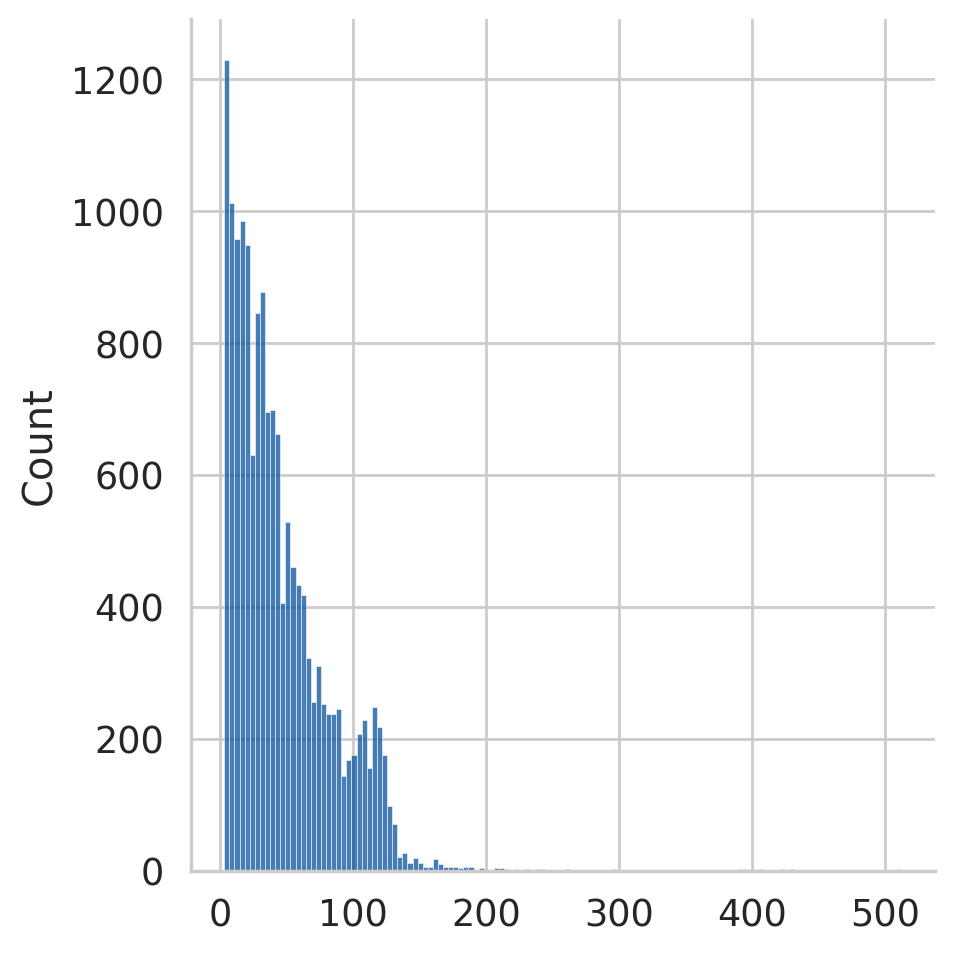

In [34]:
# Visualize the token count by the bert model
sns.displot(bert_token_lengths)
plt.show()

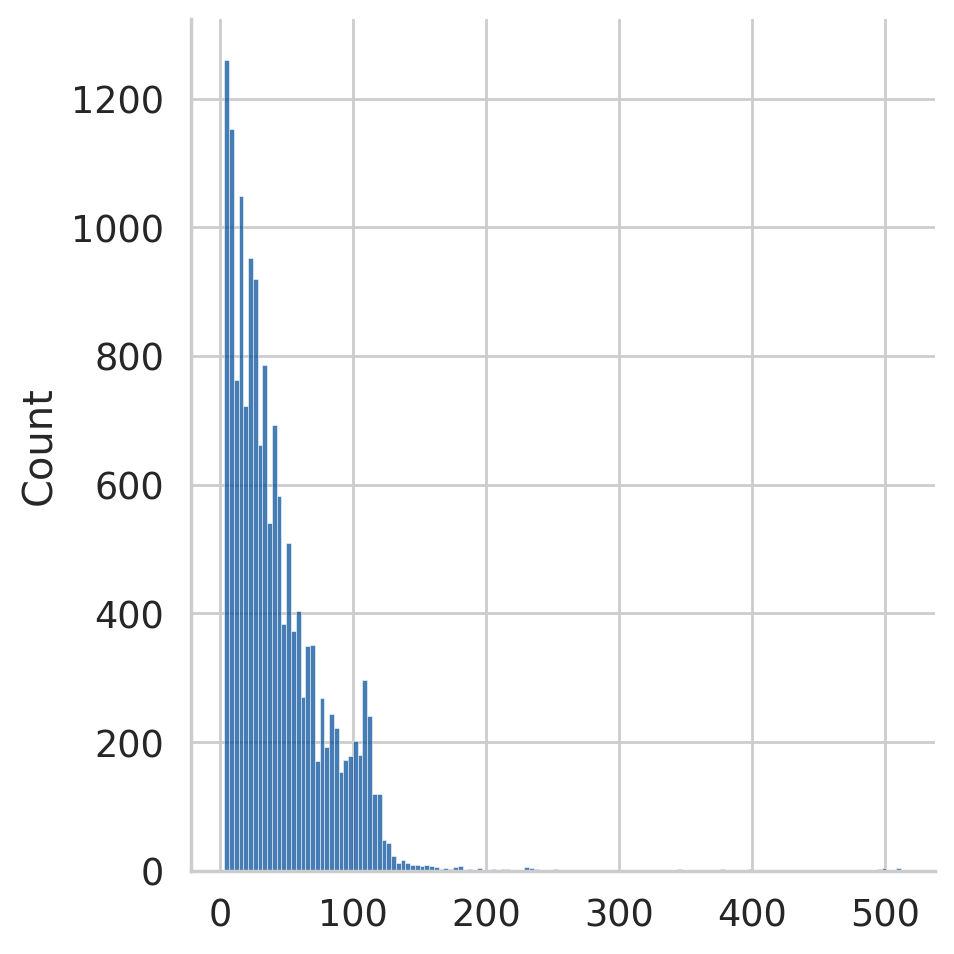

In [35]:
# Visualize the token count by the roberta model
sns.displot(roberta_token_lengths)
plt.show()

The token count is almost similar from both bert and roberta tokenizers. Seems like the most optimum length for both models to handle is 200 tokens.

In [36]:
# Create a pytorch dataset
class ReviewDataset(Dataset):

  def __init__(self, review, targets, tokenizer, max_len):
    self.review = review
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      truncation = True,
      add_special_tokens = True,
      padding = 'max_length',
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt'
    )

    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }


In [37]:
# Specify the training metrics
MAX_LEN = 200
BATCH_SIZE = 16
EPOCHS = 10

In [38]:
# Split the datasets into training, validation and testing datasets
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [39]:
# Inspect the shape of the training dataset
df_train.shape

(14171, 12)

In [40]:
# Inspect the shape of the validation dataset
df_val.shape

(787, 12)

In [41]:
# Inspect the shape of the testing dataset
df_test.shape

(788, 12)

In [42]:
# Create a data loader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
      review=df.content.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len,
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4,
  )

In [43]:
# Create data loaders using the bert tokenizer
bert_train_dl = create_data_loader(df_train, bert_tokenizer, MAX_LEN, BATCH_SIZE)
bert_validation_dl = create_data_loader(df_val, bert_tokenizer, MAX_LEN, BATCH_SIZE)
bert_test_dl = create_data_loader(df_test, bert_tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [44]:
# Create data loaders using the roberta tokenizer
roberta_train_dl = create_data_loader(df_train, roberta_tokenizer, MAX_LEN, BATCH_SIZE)
roberta_validation_dl = create_data_loader(df_val, roberta_tokenizer, MAX_LEN, BATCH_SIZE)
roberta_test_dl = create_data_loader(df_test, roberta_tokenizer, MAX_LEN, BATCH_SIZE)

In [45]:
# Inspect the keys in bert's training data
bert_data = next(iter(bert_train_dl))
bert_data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [46]:
print(f'input ids: {bert_data["input_ids"].shape}\nattention mask: {bert_data["attention_mask"].shape}\ntargets: {bert_data["targets"].shape}')

input ids: torch.Size([16, 200])
attention mask: torch.Size([16, 200])
targets: torch.Size([16])


In [47]:
# Inspect the keys in bert's training data
roberta_data = next(iter(roberta_train_dl))
roberta_data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [48]:
roberta_data['input_ids'].shape

torch.Size([16, 200])

In [49]:
# Get the BERT pre-trained model
pretrained_bert_model = AutoModel.from_pretrained(pre_trained_bert)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [50]:
# Get the RoBERTa pre-trained model
pretrained_roberta_model = AutoModel.from_pretrained(pre_trained_roberta)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# Inspect the last hidden state and pooler_output from the pretrained BERT model
bert_model_output = pretrained_bert_model(
    input_ids=bert_encoding['input_ids'],
    attention_mask=bert_encoding['attention_mask']
)

In [52]:
bert_model_output.last_hidden_state.shape

torch.Size([1, 32, 768])

In [53]:
bert_model_output.pooler_output.shape

torch.Size([1, 768])

In [54]:
# Inspect the last hidden state and pooler_outputs from the pretrained RoBERTa model
roberta_model_output = pretrained_roberta_model(
    input_ids=roberta_encoding['input_ids'],
    attention_mask=roberta_encoding['attention_mask']
)

In [55]:
roberta_model_output.last_hidden_state.shape

torch.Size([1, 32, 768])

In [56]:
roberta_model_output.pooler_output.shape

torch.Size([1, 768])

# Building the sentiment classifier

In [57]:
# Build a sentiment classifier using the BERT pretrained model
class BertSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BertSentimentClassifier, self).__init__()
    self.pretrained_bert = AutoModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.pretrained_bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.pretrained_bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
        return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [58]:
# Build a sentiment classifier using the RoBERTa pretrained model
class RobertaSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(RobertaSentimentClassifier, self).__init__()
    self.pretrained_roberta = AutoModel.from_pretrained(pre_trained_roberta)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.pretrained_roberta.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.pretrained_roberta(
        input_ids = input_ids,
        attention_mask = attention_mask,
        return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [59]:
bert_model = BertSentimentClassifier(len(sentiment_classes))
bert_model = bert_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [60]:
bert_input_ids = bert_data['input_ids'].to(device)
bert_attention_mask = bert_data['attention_mask'].to(device)

print(bert_input_ids.shape)
print(bert_attention_mask.shape)

torch.Size([16, 200])
torch.Size([16, 200])


In [61]:
F.softmax(bert_model(bert_input_ids, bert_attention_mask), dim=1)

tensor([[0.2346, 0.0835, 0.6819],
        [0.3989, 0.1595, 0.4416],
        [0.2131, 0.1286, 0.6583],
        [0.3328, 0.0870, 0.5801],
        [0.2685, 0.0739, 0.6576],
        [0.2378, 0.1974, 0.5648],
        [0.4090, 0.0858, 0.5052],
        [0.3431, 0.1955, 0.4615],
        [0.4858, 0.1022, 0.4120],
        [0.3474, 0.1402, 0.5123],
        [0.3262, 0.0925, 0.5813],
        [0.1927, 0.1052, 0.7021],
        [0.2127, 0.1265, 0.6608],
        [0.2355, 0.1641, 0.6004],
        [0.2452, 0.0665, 0.6884],
        [0.2732, 0.1094, 0.6174]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [62]:
# Add the output layer for the roberta model
roberta_model = RobertaSentimentClassifier(len(sentiment_classes))
roberta_model = roberta_model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
roberta_input_ids = roberta_data['input_ids'].to(device)
roberta_attention_mask = roberta_data['attention_mask'].to(device)

print(roberta_input_ids.shape)
print(roberta_attention_mask.shape)

torch.Size([16, 200])
torch.Size([16, 200])


In [64]:
F.softmax(roberta_model(roberta_input_ids, roberta_attention_mask), dim=1)

tensor([[0.3868, 0.3802, 0.2330],
        [0.4263, 0.3225, 0.2512],
        [0.4030, 0.3510, 0.2460],
        [0.3455, 0.3663, 0.2882],
        [0.3405, 0.3810, 0.2785],
        [0.3745, 0.3461, 0.2795],
        [0.3638, 0.3349, 0.3012],
        [0.3338, 0.3702, 0.2960],
        [0.3718, 0.3736, 0.2546],
        [0.3860, 0.3723, 0.2417],
        [0.3712, 0.3718, 0.2571],
        [0.3489, 0.3727, 0.2784],
        [0.3416, 0.4029, 0.2555],
        [0.3683, 0.3697, 0.2619],
        [0.3942, 0.3793, 0.2265],
        [0.3674, 0.3697, 0.2629]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training

In [65]:
# Create an optimizer for the BERT model
bert_optimizer = AdamW(bert_model.parameters(), lr=2e-5, correct_bias=False)
bert_total_steps = len(bert_train_dl) * EPOCHS
bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=0,
    num_training_steps=bert_total_steps
)
bert_loss_func = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [66]:
# Create an optimizer for the RoBERTa model
roberta_optimizer = AdamW(roberta_model.parameters(), lr=2e-5, correct_bias=False)
roberta_total_steps = len(roberta_train_dl) * EPOCHS
roberta_scheduler = get_linear_schedule_with_warmup(
    roberta_optimizer,
    num_warmup_steps=0,
    num_training_steps=roberta_total_steps
)
roberta_loss_func = nn.CrossEntropyLoss().to(device)

In [67]:
# Create a helper function to train the models
def train_epoch(
    model,
    data_loader,
    loss_func,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_func(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [68]:
# Create a helper function for model evaluation
def eval_model(model, data_loader, loss_func, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_func(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [69]:
# Train the BERT model and save the best model state
%%time
bert_history = defaultdict(list)
bert_best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  bert_train_acc, bert_train_loss = train_epoch(
      bert_model,
      bert_train_dl,
      bert_loss_func,
      bert_optimizer,
      device,
      bert_scheduler,
      len(df_train)
  )

  print(f'Train loss: {bert_train_loss}, Train Accuracy: {bert_train_acc}')

  bert_val_acc, bert_val_loss = eval_model(
      bert_model,
      bert_validation_dl,
      bert_loss_func,
      device,
      len(df_val)
  )

  print(f'Validation loss: {bert_val_loss}, Validtion Accuracy: {bert_val_acc}')
  print('\n')

  bert_history['train_acc'].append(bert_train_acc)
  bert_history['train_loss'].append(bert_train_loss)
  bert_history['val_acc'].append(bert_val_acc)
  bert_history['val_loss'].append(bert_val_loss)

  if bert_val_acc > bert_best_accuracy:
    torch.save(bert_model.state_dict(), 'best_bert_model_state.bin')
    bert_best_accuracy = bert_val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss: 0.7296035268909506, Train Accuracy: 0.6715122433138099
Validation loss: 0.5906335982680321, Validtion Accuracy: 0.7522236340533672


Epoch 2/10
----------
Train loss: 0.42601998327783486, Train Accuracy: 0.8400959706442735
Validation loss: 0.5463307625427842, Validtion Accuracy: 0.832274459974587


Epoch 3/10
----------
Train loss: 0.2441493305769217, Train Accuracy: 0.9211770517253546
Validation loss: 0.6750774677097797, Validtion Accuracy: 0.8500635324015248


Epoch 4/10
----------
Train loss: 0.16320461280508342, Train Accuracy: 0.9539905440688731
Validation loss: 0.7314430114009883, Validtion Accuracy: 0.8653113087674714


Epoch 5/10
----------
Train loss: 0.11751226230839039, Train Accuracy: 0.966198574553666
Validation loss: 0.7832739899144507, Validtion Accuracy: 0.8716645489199493


Epoch 6/10
----------
Train loss: 0.08945922979522779, Train Accuracy: 0.9745254392773975
Validation loss: 0.8448202995763858, Validtion Accuracy: 0.8754764930114358


Epoch 7/10
-------

In [70]:
# Train the RoBERTa model and save the best state
%%time
roberta_history = defaultdict(list)
roberta_best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  roberta_train_acc, roberta_train_loss = train_epoch(
      roberta_model,
      roberta_train_dl,
      roberta_loss_func,
      roberta_optimizer,
      device,
      roberta_scheduler,
      len(df_train)
  )

  print(f'Train loss: {roberta_train_loss}, Train Accuracy: {roberta_train_acc}')

  roberta_val_acc, roberta_val_loss = eval_model(
      roberta_model,
      roberta_validation_dl,
      roberta_loss_func,
      device,
      len(df_val)
  )

  print(f'Validation loss: {roberta_val_loss}, Validtion Accuracy: {roberta_val_acc}')
  print('\n')

  roberta_history['train_acc'].append(roberta_train_acc)
  roberta_history['train_loss'].append(roberta_train_loss)
  roberta_history['val_acc'].append(roberta_val_acc)
  roberta_history['val_loss'].append(roberta_val_loss)

  if roberta_val_acc > roberta_best_accuracy:
    torch.save(roberta_model.state_dict(), 'best_roberta_model_state.bin')
    best_accuracy = roberta_val_acc

Epoch 1/10
----------
Train loss: 0.7927758248342079, Train Accuracy: 0.6392632841719004
Validation loss: 0.646436739563942, Validtion Accuracy: 0.7369758576874206


Epoch 2/10
----------
Train loss: 0.5893091530482333, Train Accuracy: 0.7538635240985111
Validation loss: 0.6429062584042549, Validtion Accuracy: 0.7687420584498095


Epoch 3/10
----------
Train loss: 0.44724538448449586, Train Accuracy: 0.8358619716322067
Validation loss: 0.6091054909676313, Validtion Accuracy: 0.806861499364676


Epoch 4/10
----------
Train loss: 0.3547842521872161, Train Accuracy: 0.8830710606167526
Validation loss: 0.6442283390462399, Validtion Accuracy: 0.832274459974587


Epoch 5/10
----------
Train loss: 0.3020994986368566, Train Accuracy: 0.9087573212899585
Validation loss: 0.6355070746131242, Validtion Accuracy: 0.8564167725540026


Epoch 6/10
----------
Train loss: 0.26086322738763795, Train Accuracy: 0.9292216498482817
Validation loss: 0.673140569459647, Validtion Accuracy: 0.8589580686149937




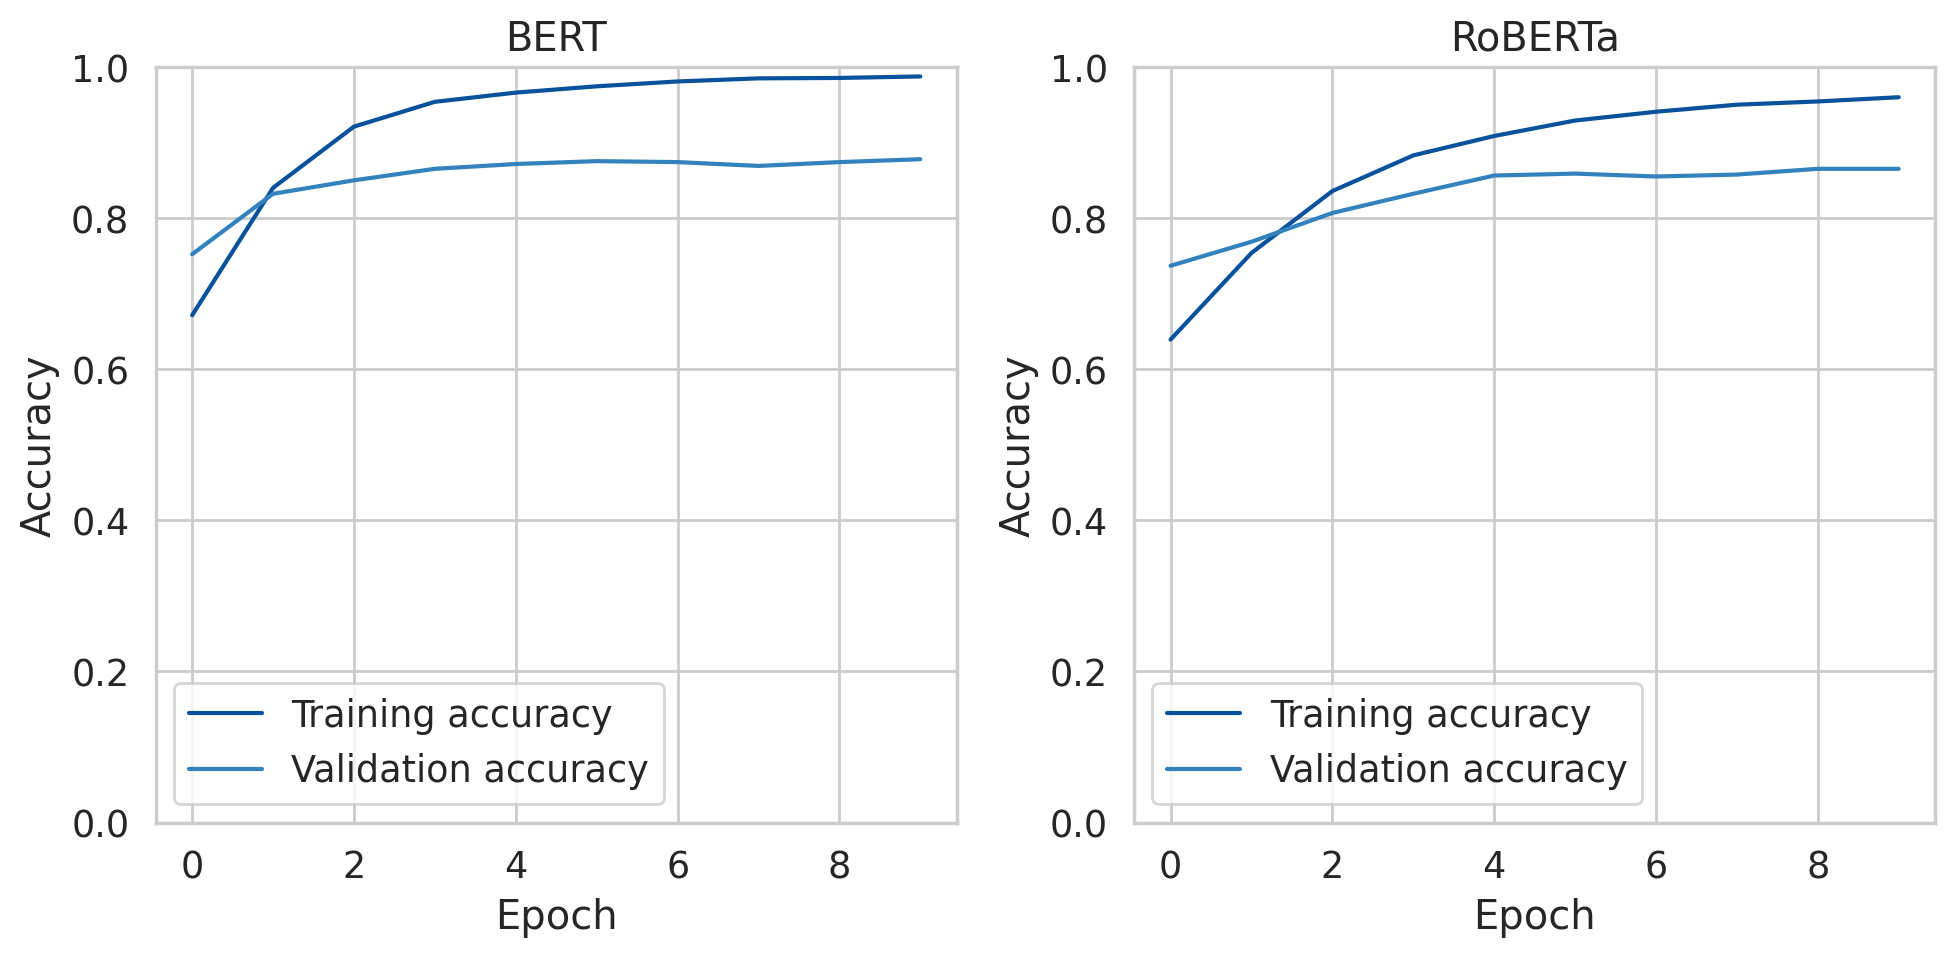

In [71]:
# Get BERT training history
bert_train_acc_cpu = []
bert_val_acc_cpu = []

for epoch_acc in bert_history['train_acc']:
  bert_train_acc_cpu.append(epoch_acc.cpu())

for epoch_acc in bert_history['val_acc']:
  bert_val_acc_cpu.append(epoch_acc.cpu())

# Get RoBERTa training history
roberta_train_acc_cpu = []
roberta_val_acc_cpu = []

for epoch_acc in roberta_history['train_acc']:
  roberta_train_acc_cpu.append(epoch_acc.cpu())

for epoch_acc in roberta_history['val_acc']:
  roberta_val_acc_cpu.append(epoch_acc.cpu())

# Plot BERT training history and RoBERTa's training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(bert_train_acc_cpu, label='Training accuracy')
ax1.plot(bert_val_acc_cpu, label='Validation accuracy')
ax1.set_title('BERT')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylim([0, 1])
ax1.legend()

ax2.plot(roberta_train_acc_cpu, label='Training accuracy')
ax2.plot(roberta_val_acc_cpu, label='Validation accuracy')
ax2.set_title('RoBERTa')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 1])
ax2.legend()

plt.tight_layout()
plt.show()

# Evaluation

In [72]:
# Test the accuracy of the fine-tuned BERT model
bert_test_acc, _ = eval_model(
    bert_model,
    bert_test_dl,
    bert_loss_func,
    device,
    len(df_test)
)

# Test the accuracy of the fine_tuned RoBERTa model
roberta_test_acc, _ = eval_model(
    roberta_model,
    roberta_test_dl,
    bert_loss_func,
    device,
    len(df_test)
)

print(f'BERT Test Accuracy: {bert_test_acc.item()}')
print(f'RoBERTa Test Accuracy: {roberta_test_acc.item()}')

BERT Test Accuracy: 0.9010152284263959
RoBERTa Test Accuracy: 0.8654822335025381


In [73]:
# Define a helper function to get predictions from model
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d['review_text']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [74]:
# Get BERT predictions
bert_y_review_texts, bert_y_pred, bert_y_pred_probs, bert_y_test = get_predictions(
    bert_model,
    bert_test_dl
)

In [75]:
# Get RoBERTa predictions
roberta_y_review_texts, roberta_y_pred, roberta_y_pred_probs, roberta_y_test = get_predictions(
    roberta_model,
    roberta_test_dl
)

In [76]:
# Display BERT's classification report
print(classification_report(bert_y_test, bert_y_pred, target_names=sentiment_classes))

              precision    recall  f1-score   support

    negative       0.93      0.86      0.89       245
     neutral       0.85      0.90      0.87       254
    positive       0.93      0.93      0.93       289

    accuracy                           0.90       788
   macro avg       0.90      0.90      0.90       788
weighted avg       0.90      0.90      0.90       788



In [77]:
# Display RoBERTa's classification report
print(classification_report(roberta_y_test, roberta_y_pred, target_names=sentiment_classes))

              precision    recall  f1-score   support

    negative       0.91      0.82      0.87       245
     neutral       0.80      0.84      0.82       254
    positive       0.90      0.92      0.91       289

    accuracy                           0.87       788
   macro avg       0.87      0.86      0.86       788
weighted avg       0.87      0.87      0.87       788



In [78]:
# Visualize the confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Reds")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

bert_cm = confusion_matrix(bert_y_test, bert_y_pred)
roberta_cm = confusion_matrix(roberta_y_test, roberta_y_pred)

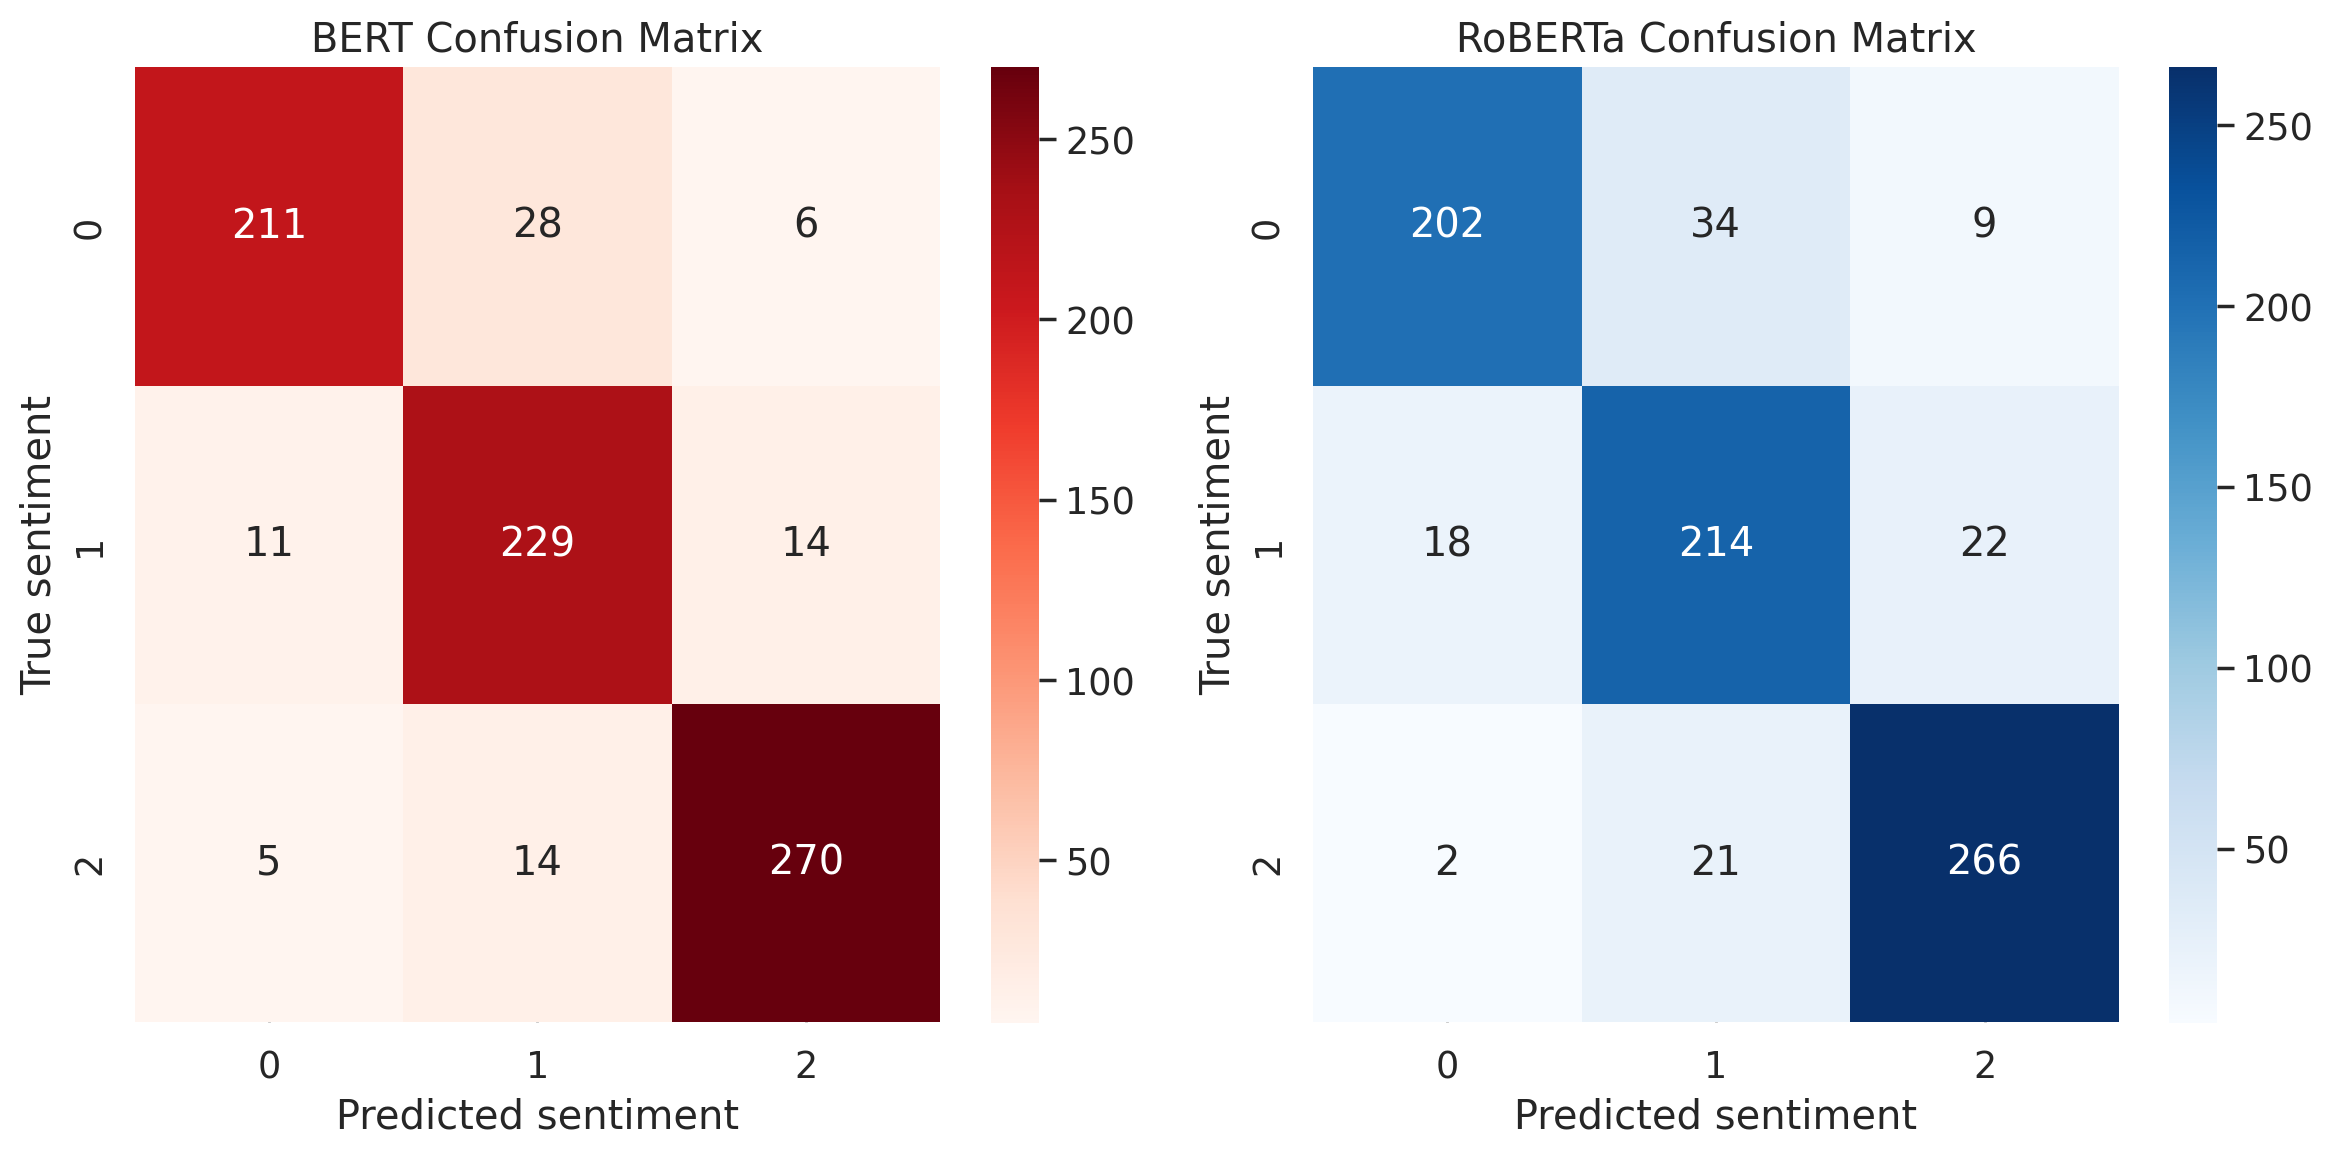

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(bert_cm, annot=True, fmt="d", cmap="Reds", ax=ax1)
ax1.set_title("BERT Confusion Matrix")
ax1.set_xlabel("Predicted sentiment")
ax1.set_ylabel("True sentiment")

sns.heatmap(roberta_cm, annot=True, fmt="d", cmap="Blues", ax=ax2)
ax2.set_title("RoBERTa Confusion Matrix")
ax2.set_xlabel("Predicted sentiment")
ax2.set_ylabel("True sentiment")

plt.tight_layout()
plt.show()

In [80]:
positive_course_review = 'I love this course'
neutral_course_review = 'This course is not bad and not good either, it is just ok'
negative_course_review = 'I hate this course'

course_reviews = [positive_course_review, neutral_course_review, negative_course_review]

for review in course_reviews:
  encoded_reviews = []
  encoded_course_review = bert_tokenizer.encode_plus(
      review,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt'
  )

  encoded_reviews.append(encoded_course_review)
  input_ids = encoded_reviews[0]['input_ids'].to(device)
  attention_mask = encoded_reviews[0]['attention_mask'].to(device)
  output = bert_model(
      input_ids=input_ids,
      attention_mask=attention_mask
  )

  _, prediction = torch.max(output, dim=1)
  print(f'Review: {review}\nSentiment : {sentiment_classes[prediction]}')


Review: I love this course
Sentiment : positive
Review: This course is not bad and not good either, it is just ok
Sentiment : neutral
Review: I hate this course
Sentiment : negative


In [81]:
for review in course_reviews:
  encoded_reviews = []
  encoded_course_review = roberta_tokenizer.encode_plus(
      review,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt'
  )

  encoded_reviews.append(encoded_course_review)
  input_ids = encoded_reviews[0]['input_ids'].to(device)
  attention_mask = encoded_reviews[0]['attention_mask'].to(device)
  output = roberta_model(
      input_ids=input_ids,
      attention_mask=attention_mask
  )

  _, prediction = torch.max(output, dim=1)
  print(f'Review: {review}\nSentiment : {sentiment_classes[prediction]}')

Review: I love this course
Sentiment : positive
Review: This course is not bad and not good either, it is just ok
Sentiment : neutral
Review: I hate this course
Sentiment : negative
